In [17]:
import pandas as pd 
import numpy as np 
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from torchvision.io import read_image
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*iCCP: known incorrect sRGB profile.*")
warnings.filterwarnings("ignore", category=UserWarning, module=".*libpng.*")


# Deep Neural Networks Laboratory

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset Preparation

In [19]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
test = pd.read_csv(os.path.join('data','pokemon','annotations_file.csv'))

In [21]:
test.iloc[5,0]

'0001_Inspired.png'

In [22]:
folder = os.path.join('data','pokemon')
pokemon_dataset = CustomImageDataset(annotations_file=os.path.join(folder,'annotations_file.csv'), img_dir=os.path.join(folder,'imgs'), transform=None, target_transform=None)

In [23]:
train_size = int(0.9 * len(pokemon_dataset))
test_size = len(pokemon_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(pokemon_dataset, [train_size, test_size])

In [24]:
train_dataset

In [25]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [26]:
labels_map = pd.read_csv(os.path.join(folder,'emotion_mapping.csv'))
labels_map = labels_map.to_dict()['em']

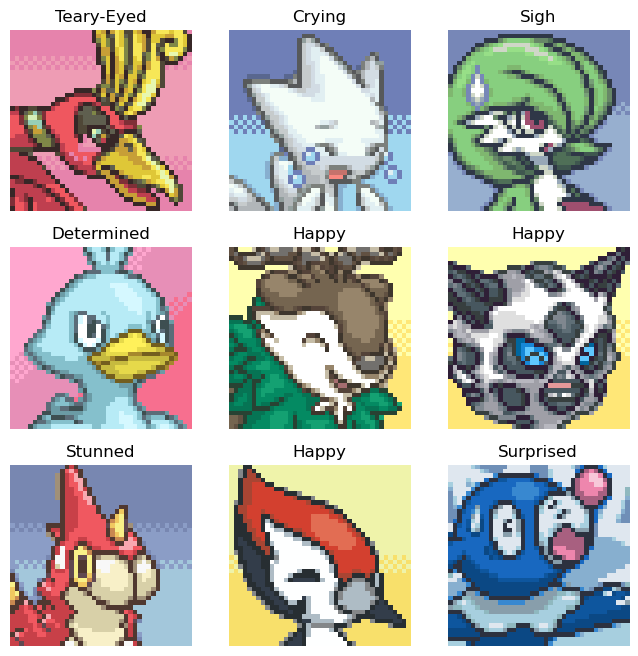

In [27]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    
    img, label = train_dataset[sample_idx]

    img_rgb = img[:3, :, :]

    img_np = img_rgb.numpy()

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(img_np, (1, 2, 0)))  

plt.show()

## Convolutional Neural Network

In [28]:
class Net(nn.Module):
    def __init__(self, num_classes=len(labels_map)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 7 * 7, 200)  
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x.float())))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [29]:
net.to(device)

Net(
  (conv1): Conv2d(4, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=16, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [30]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 1000 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  # torch save model with torch.save()
  torch.save({'model_weights': model.state_dict()}, 'model.pt')

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return (100*correct)

In [31]:
learning_rate = 1e-4
batch_size = 32
epochs = 250

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

accuracies = []
losses = []

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, net, loss_fn, optimizer)
  accuracies.append(test_loop(test_dataloader, net, loss_fn))
print("Done!")

Epoch 1
-------------------------------
loss: 4.542046  [   32/ 9196]


Test Error: 
 Accuracy: 25.0%, Avg loss: 2.185153 

Epoch 2
-------------------------------
loss: 1.983981  [   32/ 9196]
Test Error: 
 Accuracy: 32.2%, Avg loss: 1.850776 

Epoch 3
-------------------------------
loss: 1.822965  [   32/ 9196]
Test Error: 
 Accuracy: 36.1%, Avg loss: 1.671767 

Epoch 4
-------------------------------
loss: 1.848091  [   32/ 9196]
Test Error: 
 Accuracy: 42.5%, Avg loss: 1.575981 

Epoch 5
-------------------------------
loss: 1.141534  [   32/ 9196]
Test Error: 
 Accuracy: 43.6%, Avg loss: 1.530222 

Epoch 6
-------------------------------
loss: 1.092892  [   32/ 9196]
Test Error: 
 Accuracy: 45.2%, Avg loss: 1.451797 

Epoch 7
-------------------------------
loss: 1.068038  [   32/ 9196]
Test Error: 
 Accuracy: 48.9%, Avg loss: 1.402593 

Epoch 8
-------------------------------
loss: 0.810874  [   32/ 9196]
Test Error: 
 Accuracy: 44.9%, Avg loss: 1.453419 

Epoch 9
-------------------------------
loss: 0.996188  [   32/ 9196]
Test Error: 
 Accuracy: 

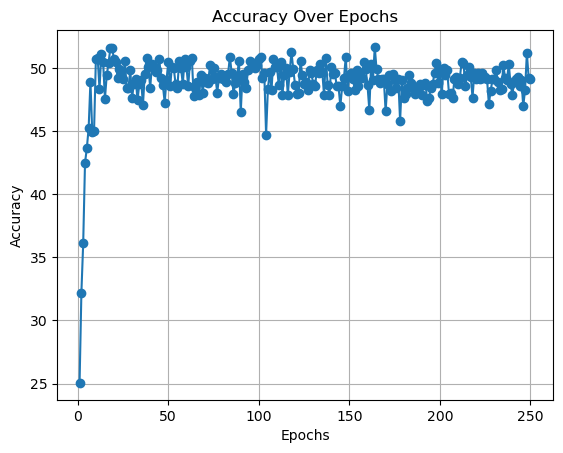

In [33]:
import matplotlib.pyplot as plt

epochs = range(1, len(accuracies) + 1)

plt.plot(epochs, accuracies, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

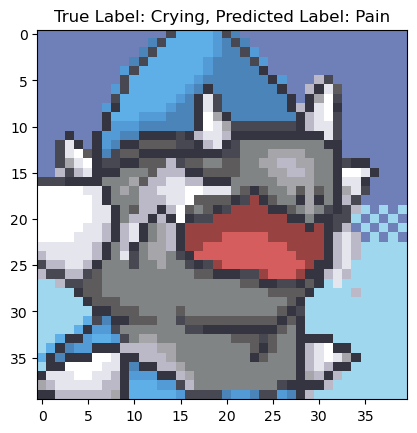

In [60]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random



net.eval()

sample_index = random.randint(0, len(test_dataset) - 1)  
sample_image, true_label = test_dataset[sample_index]

sample_image = sample_image.unsqueeze(0).to(device)

with torch.no_grad():
    model_output = net(sample_image)

predicted_label = torch.argmax(model_output, dim=1).item()

image = transforms.ToPILImage()(sample_image.squeeze(0))

# Display the image and prediction
plt.imshow(image)
plt.title(f'True Label: {labels_map[true_label]}, Predicted Label: {labels_map[predicted_label]}')
plt.show()
